<center><h1 style="font-family: cambria;font-size:40px;"> Fourier Transform in MRI:<br> Mathematical theory and related artefacts</h1></center>

In [1]:
# Importing the libraries/functions required to run this notebook

import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rc('image', cmap='gray') # Set default image colormap as gray
import numpy as np

from IPython.display import HTML
from numpy.fft import * 

# Introduction

## Who is Joseph Fourier ?

**Jean Baptiste Joseph Fourier** (1768-1830) was a **french mathematician and physicist** that notably investigated the Fourier Series theorem that states that ***any signal can be decomposed into a sum of sinusoidal sub-signals, each having its own frequency, magnitude and phase***. This property later became one of the most fundamental tool for signal processing, especially in Magnetic Resonance Imaging where this duality between the spatial evolution of a signal and its frequency/magnitude/phase components is the bedrock of the image reconstruction process.

<figure><center>
  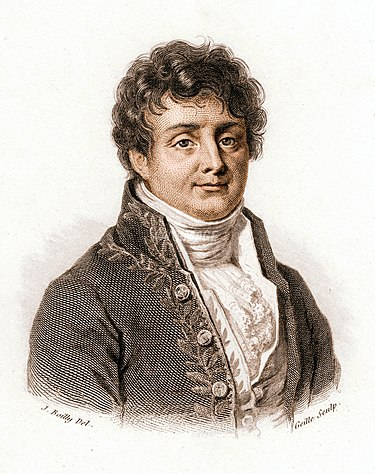
    <figcaption> <i>Joseph Fourier (1768 - 1830)</i> </figcaption></center>
</figure>



Fourier is notably known for: 
- Proposing the **Fourier number** (Heat transfer)
- Discovering the **Fourier series** (Mathematics)
- Proposing the **Fourier Transform** formulas (Mathematics)
- Establishing the **Fourier's law of conduction** (Heat transfer)
- Proposing the **Fourier-Motzkin elimination** algorithm (Mathematics)
- Dicscovering the **greenhouse effect** (Heat transfer)

## Fourier series: everything is sinusoidal!
As previously mentionned, Fourier demonstrated that any signal can be decomposed into a sum of sinusoidal sub-signals, each having its own **frequency**, **magnitude** and **phase**. 

The animation below shows how a square signal $s(t)$ can be decomposed in many sinusoids of different frequencies and amplitudes (in this particular example, they all have the same phase): 

<center> $s_{square}(t) = \sum\limits_{n=0}^{\infty}\frac{4}{\pi (2n+1)}\times sin((2n+1)t) $ </center>

![square_signal_decomposition](./utils/animations/square_signal_decomposition.gif "segment")

As we can see on the animation, **the more sinusoids we use, the better the square signal is approximated**. This means that perfectly aproaching a square signal would require an infinity of sinusoids, which is obviously impossible to reach in practice. But we will later see that we can still get a good approximation with a finite number of sinusoids.

In the same manner, any signal can thus be approximated by summing a sufficient amount of sinusoids (summing the same number of sinusoids as the number of samples in the signal should result in an exact reproduction of the signal). The animation below illustrates this with a dummy signal composed of 20 samples:

![SegmentLocal](utils/animations/dummy_signal_decomposition.gif "segment")

We indeed see that summing 20 sinusoids results in a perfect representation of the original signal with 20 samples.

## The Fourier Domain: just another way of seeing things

In the Fourier Domain, **each point represents a sinusoidal component of the signal**. These sinusoids are sorted by frequency in the Fourier Domain. Two different ways of representing the Fourier Domain are commonly used:

- The **non-shifted Fourier Domain**: Ranging from low to high frequencies ($Range: [0, F_s]$, $F_s$ being the sampling frequency of the signal),
- The **shifted Fourier Domain**: High frequencies are located on the edges of the Fourier Domain, and the 0Hz component (mean) of the signal is represented in the center. ($Range: [-\frac{F_s}{2}, \frac{F_s}{2}]$)

The Fourier Domain is thus a mathematical representation of a signal in terms of **frequency**. It has a magnitude component and a phase component, it is thus a **complex domain**.

The highest frequency represented corresponds to the sampling frequency of the signal. 

Sometimes, the Fourier Domain is referred to as the **k-space** (we will later see why). This is particularly true in the MRI community.

### Fourier transform

The Fourier Transform is a very powerful mathematical tool that allows us to go back and forth between the spatial (or temporal) domain and the frequency domain (Fourier Domain). In other words, it switches between the spatial representation of a signal (i.e. an image), and the frequency/phase representation of the signal. This two representations are equivalent, as they relate to the same signal, but they have different utilities. For example, the Fourier domain will come handy when we need to visualize the main frequencies that compose a signal, in order to filter it for example.

### Continuous  Fourier Transform

For a continuous signal $s$ (infinite number of points), its Fourier transform $S$ will be given by the following formula:

$S(f) = \int\limits_{-\infty}^{\infty}s(t) e^{-i2\pi ft}dt$

Reciprocally, the signal $s$ can be retrieved from $S$ according to the **inverse Fourier Transform** formula:

$s(t) = \int\limits_{-\infty}^{\infty}S(f) e^{i2\pi ft}df$


### Discrete Fourier Transform

For a discrete signal $s$ composed of $N$ samples, a similar formula can be written down as:

$ S(k) = \sum\limits_{n=0}^{N-1} s(n)e^{-i2\pi \frac{k}{N}n}, \hspace{5mm} for \hspace{5mm} 0 \leqslant k \ < N $

The discrete inverse Fourier Transform formula will then be:

$ s(n) = \frac{1}{N}\sum\limits_{k=0}^{N-1} S(k)e^{i2\pi \frac{n}{N}k} $

We can see here that the letter **k** is used as the variable for the discrete Fourier Domain. This is why it is sometimes reffered to as the **k-space**.


The most common algorithm to compute the Fourier Transforms of discrete signals is the [***fast Fourier Transform***](https://en.wikipedia.org/wiki/Fast_Fourier_transform), usually reffered to as **FFT**. Here we will use a Python implementation of this algorithm available in the `numpy.fft` package.

For a real signal $s$, $S$ will be complex, with both magnitude and phase components being of interest for the processing of the signal.

<br><br>

In order to better visualize how all of this works, we will use the example a a signal composed of 3 sinusoids with different amplitudes, frequencies and phases:
<br><br>

<center>$s_1=\sin(2\pi t), \hspace{5mm} s_2=\dfrac{\sin(20 \pi  t +\frac{\pi}{2})}{3},\hspace{5mm} s_3 = \dfrac{\sin(10 \pi  t +\pi)}{5}$</center>

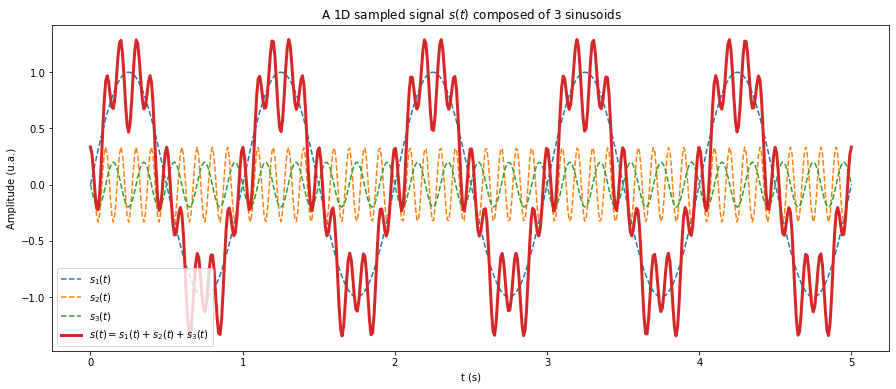

In [2]:
Fs = 100                                     # Sampling frequency (Hz)
t_0 = 0                                      # Sampling starting time (s)
t_max = 5                                    # Sampling ending time (s)
nb_samples = (t_max - t_0)* Fs               # Number of samples (=500)
t = np.linspace(t_0, t_max, nb_samples)      # Creation of the temporal vector (duration: 5 s ; sampling frequency: 100Hz)

s1 = np.sin(t * 2 * np.pi)                   # Signal s1 --> Amplitude: 1   a.u. ; Frequency: 1 Hz ; Phase: 0 rad
s2 = np.sin(t * 20 * np.pi + np.pi / 2) / 3  # Signal s2 --> Amplitude: 1/3 a.u. ; Frequency: 10  Hz ; Phase: pi/2 rad
s3 = np.sin(t * 10 * np.pi + np.pi) / 5       # Signal s3 --> Amplitude: 1/5 a.u. ; Frequency: 5 Hz ; Phase: pi rad
s = s1+s2+s3                                 # Signal s (sum of all signals above)

plt.figure(figsize=[15,6])
plt.plot(t, s1, '--'); plt.plot(t, s2, '--'); plt.plot(t, s3, '--'); plt.plot(t, s, lw=3)
plt.title("A 1D sampled signal $s(t)$ composed of 3 sinusoids")
plt.legend(["$s_1(t)$", "$s_2(t)$", "$s_3(t)$", "$s(t) = s_1(t)+s_2(t)+s_3(t)$"])
plt.xlabel("t (s)")
plt.ylabel("Amplitude (u.a.)");
plt.show()

### Magnitude spectrum

The magnitude spectrum represents the amplitudes associated to each sinusoid component of the signal.

- The 0 Hz component of the magnitude spectrum represents the mean of the signal (a constant signal will only have one peak at 0Hz),
- The magnitude located at some frequency is the amplitude of the corresponding sinusoid,
- If a frequency is not present in the original signal, the corresponding magnitude value in the Fourier Domain will simply be null.

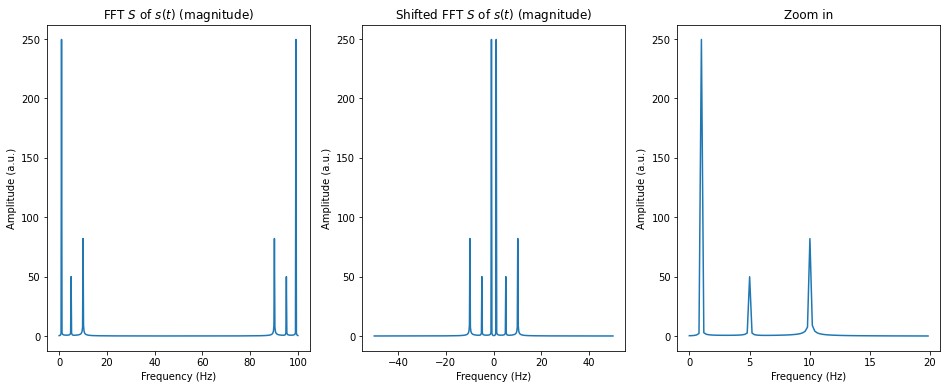

In [3]:
plt.figure(figsize=[16,6])
plt.subplot(131)
plt.plot(np.linspace(0, Fs, nb_samples),np.abs(fft(s)))
plt.title("FFT $S$ of $s(t)$ (magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")

plt.subplot(132)
plt.plot(np.linspace(-Fs/2, Fs/2, nb_samples), np.abs(fftshift(fft(s))))
plt.title("Shifted FFT $S$ of $s(t)$ (magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")

plt.subplot(133)
plt.plot(np.linspace(0, Fs, nb_samples)[:100], np.abs(fft(s))[:100])
plt.title("Zoom in")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (a.u.)")
plt.show()

We see here that we obtain 3 symmetrical peaks. In the shifted Fourier Domain, the **magnitude is an even function**. The reasons behind this symmetry will be investigated later, but it is important to notice that shifting the Fourier spectrum results in switching its second and first halves. 

For now, we are more interested in the fact that the 3 peaks are located at 3 specific frequencies: $1Hz$, $5Hz$ and $10Hz$.
The frequencies correspond to the frequencies of $s_1$, $s_3$ and $s_2$ respectively.
The relative amplitudes of the peaks also correspond to $1$, $\frac{1}{3}$ and $\frac{1}{5}$ as expected.

### Phase spectrum

For any frequency composing the signal, the corresponding phase value will represent the moment the sinusoid was "fired out" compare to a null-phase reference. It this thus very important to know the phase component of the Fourier representation of a signal.

- The phase ranges from $-\pi$ to $\pi$,
- The phase relates to the position of a sinusoid in the signal.

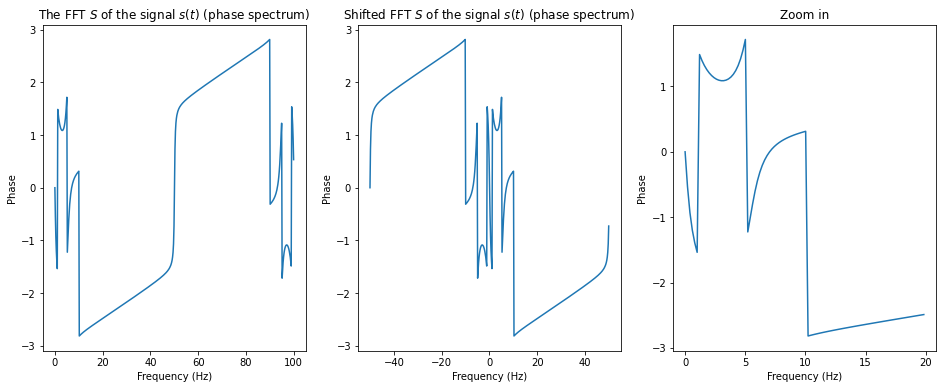

In [4]:
plt.figure(figsize=[16,6])
plt.subplot(131)
plt.plot(np.linspace(0, Fs, nb_samples),np.angle(fft(s)))
plt.title("The FFT $S$ of the signal $s(t)$ (phase spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")

plt.subplot(132)
plt.plot(np.linspace(-Fs/2, Fs/2, nb_samples), np.angle(fftshift(fft(s))))
plt.title("Shifted FFT $S$ of the signal $s(t)$ (phase spectrum)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")

plt.subplot(133)
plt.plot(np.linspace(0, Fs, nb_samples)[:100], np.angle(fft(s))[:100])
plt.title("Zoom in")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")
plt.show()

The phase spectrum is harder to understand than the magnitude spectrum, but it is interesting to notice that abrupt phase changes occur at the frequencies composing our signal. In the shifted Fourier Domain, it is also important to notice that **the phase is a odd function**.

### Aliasing and Nyquist-Shannon theorem

We have seen that the Fourier Domain ranges from $0Hz$ to $2F_s$, but what happens if some frequencies present in the signal are at least twice as large as the sampling frequency ?

The animation below shows how the sampling frequency affects the acquisition of a $5Hz$ signal: 


In [2]:
from utils.fourier_widgets import aliasing_widget
aliasing_widget()

Loading BokehJS ...

We notice here that above $10Hz$, the signal progressively degrades as $F_s$ decreases, but we cans still have a good idea of its original frequency. 

With a sampling frequency of $10Hz$ and lower, we completely miss some variation of the signal. This means that we will not be able to correctly estimate the frequency of the original signal: we will alias the true frequency for a wrong one, this is what we call **aliasing**.

In order to avoid the aliasing phenomenon, Harry Nyquist and Claude Shannon stated that a signal should be acquired with a sampling frequency **at least twice as large as the maximum frequency comprised in the signal**.

### Aliasing in the Fourier domain

As we previously saw, the frequencies are repeated in the magnitude Fourier domain. This is due to a specific property of the Fourier domain: **It is theoretically infinite and repeats every $F_s$** (this is why the second part of the non-shifted Fourier domain can be shifted before the first half, resulting in the shifted representation).

If $F_s$ does not respect the Nyquist-Shannon condition, the second occurence of the Fourier domain will overlap with the first one and this will result in a misinterpretation of the frequency content of the signal: we are once again in the presence of aliasing.

# 2D Fourier transform of images

For 2-dimensionnal $M\times N$ signal (e.g. images), the discrete Fourier Transform formula becomes:

$ S(k, l) = \sum\limits_{m=0}^{M-1}\sum\limits_{n=0}^{N-1} s(m, n)e^{-i2\pi ( \,\frac{mk}{M}+\frac{nl}{N}) \,}, \hspace{5mm} for \hspace{5mm} 0 \leqslant k \ < M,\hspace{5mm} 0 \leqslant l \ < N $

In [ ]:
brain_image = mpimg.imread('./utils/images/brain_MRI.jpg')
brain_FFT = fftshift(fft2(brain_image)) # For images, we use fft2(), the 2D equivalent of fft()

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.imshow(brain_image)
plt.title("Original image")
plt.subplot(132)
plt.imshow(np.log(np.abs(brain_FFT)))
plt.title("2D FFT of the image (magnitude)")
plt.subplot(133)
plt.imshow(np.angle(brain_FFT))
plt.title("2D FFT of the image (phase)")
plt.show()

### Frequency components

Similarly to the 1D case, the 2D shifted Fourier domain has the low frequency values in its middle, and the high frequency values on the edges.

In the 2D Fourier domain:
- The **$0Hz$ frequency** correspond to the **mean intensity** of the image. 

- **Low frequencies** correspond to slowly varying intensities across the image (big objects, light/shadows...).

- **High frequencies** correspond to abrupt intensity variations (small objects, outlines...).



In [ ]:
mask_center = np.zeros_like(brain_FFT)  # mask that only keeps the center of the FFT
mask_center[brain_FFT.shape[0]//2-10:brain_FFT.shape[0]//2+10, brain_FFT.shape[1]//2-10:brain_FFT.shape[1]//2+10] = 1
mask_edges = np.ones_like(brain_FFT)-mask_center # mask that only keeps the edges of the FFT

brain_FFT_center = brain_FFT*mask_center
brain_FFT_edges = brain_FFT*mask_edges

plt.figure(figsize=[15,15])
plt.subplot(221)
plt.imshow(np.log(np.abs(brain_FFT))*np.abs(mask_center))
plt.title("Shifted FFT (log of magnitude)")
plt.subplot(222)
plt.imshow(np.abs(ifft2(ifftshift(brain_FFT_center)))) # ifftshift() is used to go back from the Fourier to the spatial domain
plt.title("Image obtained with the center of the FFT")
plt.subplot(223)
plt.imshow(np.log(np.abs(brain_FFT))*np.abs(mask_edges))
plt.title("Shifted FFT (log of magnitude)")
plt.subplot(224)
plt.imshow(np.abs(ifft2(ifftshift(brain_FFT_edges))))
plt.title("Image obtained with the edges of the FFT")
plt.show()

On the images above, we observe that removing the edges of the FFT (i.e. keeping the low frequencies) results in a blurry images where only the general shapes can be distinguished. What we did here corresponds to a **low-pass filtering**.

On the contrary, removing the center of the FFT yields a very detailed image with an important loss of intensity. What we did here corresponds to a **high-pass filtering**.

This shows that the Fourier Transform is an interseting tool in order to perform image filtering. Compare to a spatial filtering that requires a 2D convolution of the image with a filtering elements, applying an FFT and filter by an element-wise multiplication will often be a much less computationnaly expensive solution.

### Rotations in the Fourier domain

It is quite straightforward to understand that rotating the FFT would result in a rotated image:

In [ ]:
brain_FFT_rotated = np.rot90(brain_FFT)

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.log(np.abs(brain_FFT_rotated)))
plt.title("FFT rotated by 90$\degree$")
plt.subplot(122)
plt.imshow(np.abs(ifft2(ifftshift(brain_FFT_rotated))))
plt.title("Corresponding image")
plt.show()

But what happens if we only rotate the phase or the magnitude of the image ?

#### Rotating the phase

We saw that the phase was an odd function in the Fourier domain, this means that multiplying it by $-1$ would result in a $\pi$ rotation of the phase spectrum.

In [ ]:
brain_FFT_rotated_phase = np.abs(brain_FFT)*np.exp(-1j*np.angle(brain_FFT))

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.log(np.abs(brain_FFT_rotated_phase)))
plt.title("FFT rotated by 90$\degree$")
plt.subplot(122)
plt.imshow(np.abs(ifft2(ifftshift(brain_FFT_rotated_phase))))
plt.title("Corresponding image")
plt.show()

In [ ]:
brain_FFT_rotated_magnitude = -(np.abs(brain_FFT))*np.exp(1j*np.angle(brain_FFT))

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(np.log(np.abs(brain_FFT_rotated_magnitude)))
plt.title("FFT rotated by 90$\degree$")
plt.subplot(122)
plt.imshow(np.abs(ifft2(ifftshift(brain_FFT_rotated_magnitude))))
plt.title("Corresponding image")
plt.show()

# Fourier related MRI artefacts

In Magnetic Resonance Images, we use **gradient coils** in order to encode the spatial location of the spins in the Fourier Domain. 

Indeed, the spins rotate arround the main magnetic field $B_0$ of the scanner at a certain frequency $w_0$ (**Larmor Frequency**). The larmor frequency is related to the $B_0$ strength according to the formula below: 
<center>$\omega_0 = \gamma B_0$</center>

This means that, by adding a spatial gradient to the $B_0$ field, the spins' rotation speed will spatially vary, and thus the frequency component of a measured signal will directly be linked to the spatial location of the spins emitting this signal.

## Clipping (RF overflow artifact)

## Spiking

## Fold-Over/wrap-around

## Gibbs artefact (ringing)